**CUSTOMER CHURN PREDICTION**

**Features**

1. RowNumber — the record number.

2. CustomerId — random values.

3. Surname — the surname of a customer.

4. CreditScore — a number that determines creditworthiness based on credit history.

5. Geography — a customer's location.

6. Gender — an interesting feature to explore.

7. Age — a relevant feature to explore.

8. Tenure — the number of years that the customer has been a client of the bank.

9. Balance — amount remaining in the account of the customer.

10. NumOfProducts — the number of products that a customer has purchased through the bank.

11. HasCrCard — shows whether or not a customer has a credit card. 

12. IsActiveMember — denotes active customers and non active.

13. EstimatedSalary — the salary of a customer.

14. Exited — did the customer leave the bank or not. This is what we have to predict.(0=No,1=Yes)

In [60]:
#import necessary libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#sklearn package
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

##lime package
import lime
from lime import lime_tabular

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
import pickle 

In [61]:
#import the data
df = pd.read_csv("churn.csv")

#view first observations
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [62]:
#information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [63]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [4]:
#drop unnecessary columns
df_new = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [5]:
df_new.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

**Exploratory Analysis**

In [6]:
#data information after dropping the irrelevant columns
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [7]:
#summary statistics
df_new.describe().T

count           mean           std     min       25%  \
CreditScore      10000.0     650.528800     96.653299  350.00    584.00   
Age              10000.0      38.921800     10.487806   18.00     32.00   
Tenure           10000.0       5.012800      2.892174    0.00      3.00   
Balance          10000.0   76485.889288  62397.405202    0.00      0.00   
NumOfProducts    10000.0       1.530200      0.581654    1.00      1.00   
HasCrCard        10000.0       0.705500      0.455840    0.00      0.00   
IsActiveMember   10000.0       0.515100      0.499797    0.00      0.00   
EstimatedSalary  10000.0  100090.239881  57510.492818   11.58  51002.11   
Exited           10000.0       0.203700      0.402769    0.00      0.00   

                        50%          75%        max  
CreditScore         652.000     718.0000     850.00  
Age                  37.000      44.0000      92.00  
Tenure                5.000       7.0000      10.00  
Balance           97198.540  127644.2400  250898.09  
NumOfProducts         1.000       2.0000       4.00  
HasCrCard             1.000       1.0000       1.00  
IsActiveMember        1.000       1.0000       1.00  
EstimatedSalary  100193.915  149388.2475  199992.48  
Exited                0.000       0.0000       1.00

In [8]:
def calculate_credit_score_range(credit_score):
    """
    Calculates the credit score range based on the given credit score.

    Args:
        credit_score (int): The credit score to evaluate.

    Returns:
        str: The credit score range (Excellent, VeryGood, Good, Fair, Poor).
    """

    if credit_score >= 800:
        return "Excellent"
    elif credit_score >= 740:
        return "VeryGood"
    elif credit_score >= 670:
        return "Good"
    elif credit_score >= 580:
        return "Fair"
    else:
        return

# Add a new column named "CreditScoreRange"
df["CreditScoreRange"] = df["CreditScore"].apply(calculate_credit_score_range)

# Print the updated DataFrame
print(df)

      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMemb

In [9]:
#rename dataframe 
df_n = pd.DataFrame(df)

In [10]:
df_n.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited CreditScoreRange  
0        101348.88       1             Fair  
1        112542.58       0             Fair  
2        113931.57       1             None  
3         93826.63       0             Good  
4         79084.10       0        Excellent

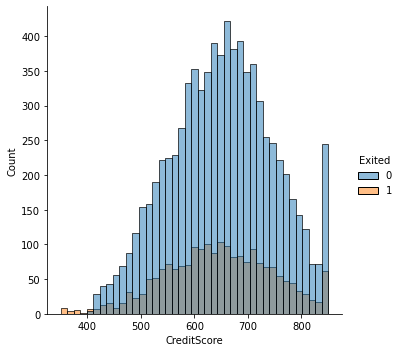

In [11]:
#the distribution of creditscore across the y value
sns.displot(df, x="CreditScore", hue="Exited")

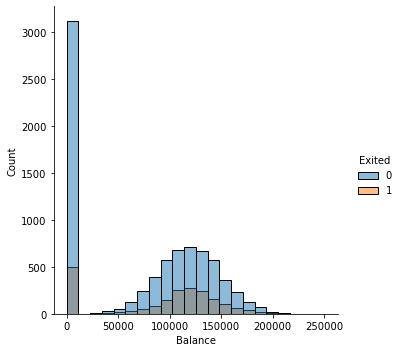

In [12]:
sns.displot(df, x="Balance", hue="Exited")

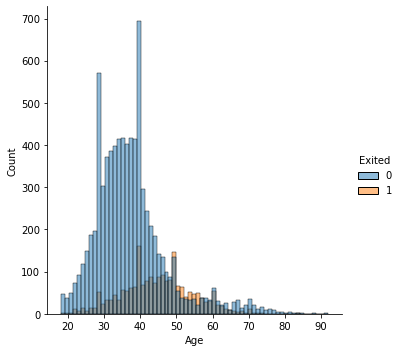

In [13]:
sns.displot(df, x="Age", hue="Exited")

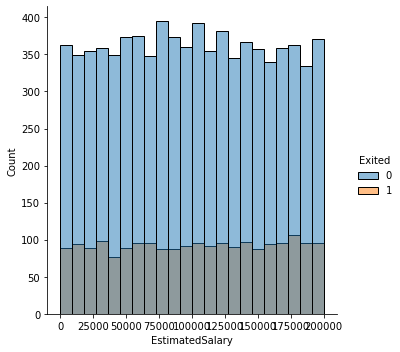

In [14]:
sns.displot(df, x="EstimatedSalary", hue="Exited")

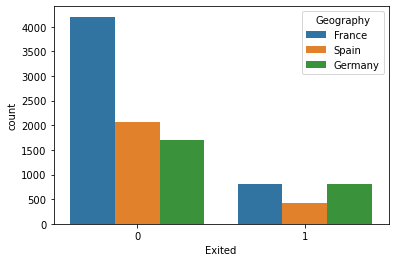

In [15]:
sns.countplot(x = "Exited", hue = "Geography", data = df)
plt.show()

In [16]:
#Sum the 'Exited' column based on  the 'Geography'
sum_exited = df.groupby('Geography')['Exited'].value_counts()

#Print the sum of 'Exited' based on unique values in the 'Geography' column
print(sum_exited)

Geography  Exited
France     0         4204
           1          810
Germany    0         1695
           1          814
Spain      0         2064
           1          413
Name: Exited, dtype: int64


In [17]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [18]:
df['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [19]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

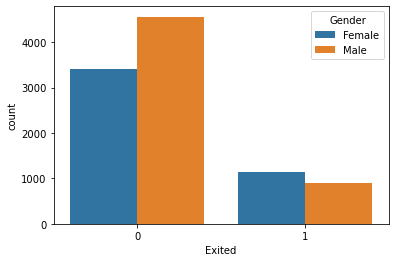

In [20]:
sns.countplot(x = "Exited", hue = "Gender", data = df)
plt.show()

In [21]:
#Sum the 'Exited' column based on  the 'HasCrCard'
sum_exited = df.groupby('Exited')['HasCrCard'].value_counts()

print(sum_exited)

Exited  HasCrCard
0       1            5631
        0            2332
1       1            1424
        0             613
Name: HasCrCard, dtype: int64


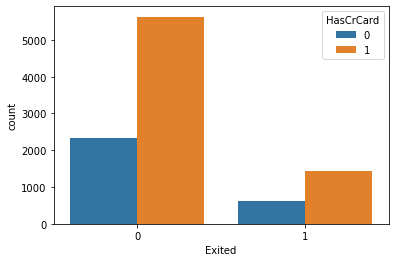

In [22]:
sns.countplot(x = "Exited", hue = "HasCrCard", data = df)
plt.show()

In [23]:
#Sum the 'Exited' column based on  the 'IsActiveMember'
sum_exited = df.groupby('Exited')['IsActiveMember'].value_counts()

print(sum_exited)

Exited  IsActiveMember
0       1                 4416
        0                 3547
1       0                 1302
        1                  735
Name: IsActiveMember, dtype: int64


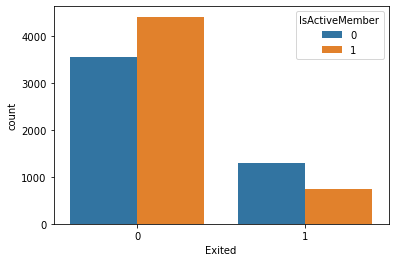

In [24]:
sns.countplot(x = 'Exited', hue ='IsActiveMember',data = df)
plt.show()

In [25]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

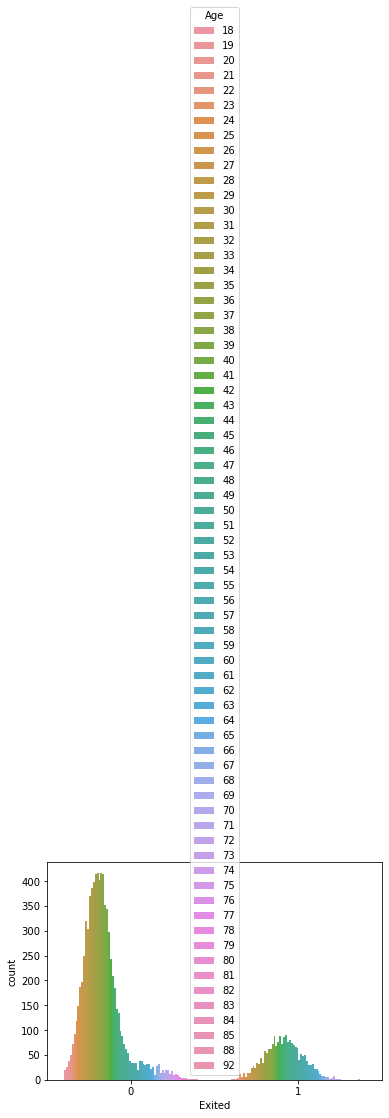

In [26]:
sns.countplot(x = "Exited", hue = "Age", data = df)
plt.show()

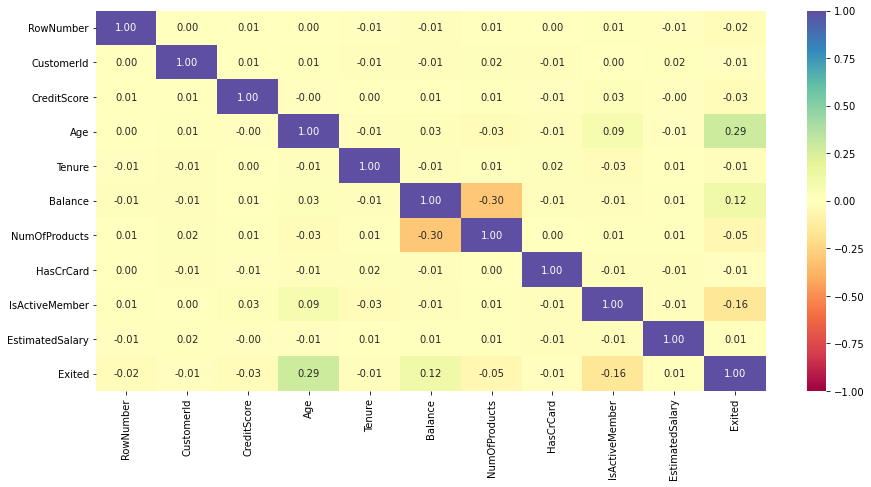

In [27]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

In [28]:
#encoding the categorical variables
le = LabelEncoder()

for col in df_new.columns:
    if df_new[col].dtype == 'object':
        df_new[col] = le.fit_transform(df_new[col])

In [29]:
#check for missing values
df_new.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [30]:
#divide the data into input matrix and output separately
X = df_new.drop(['Exited'], axis=1)
y= df_new['Exited']

In [31]:
#the size of the features and the label
X.shape, y.shape

((10000, 10), (10000,))

In [32]:
#use RFECV for feature selection

# Create a decision tree classifier
estimator = DecisionTreeClassifier()
  
# find the optimal number of features
selector = RFECV(estimator, cv=5)
selector = selector.fit(X, y)
  
# Print the optimal number of features
print("Optimal number of features: %d" % selector.n_features_)


# Print the selected features
print("Selected features: %s" % selector.support_)

Optimal number of features: 10
Selected features: [ True  True  True  True  True  True  True  True  True  True]


In [33]:
print("Selected features: %s" % selector.feature_names_in_)

Selected features: ['CreditScore' 'Geography' 'Gender' 'Age' 'Tenure' 'Balance'
 'NumOfProducts' 'HasCrCard' 'IsActiveMember' 'EstimatedSalary']


In [34]:
X = X.drop(['HasCrCard'], axis = 1)

**STANDARDIZATION**

In [35]:
# define standard scaler
scaler = StandardScaler()
  
# transform data
X_scaled = scaler.fit_transform(X)

In [36]:
#split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=0)

#the size of each sets
len(X_train), len(y_train), len(X_test), len(y_test)

(8000, 8000, 2000, 2000)

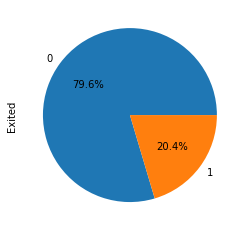

In [37]:
#the ratio of customer churn 
y_train.value_counts().plot.pie(autopct='%1.1f%%', textprops ={'fontsize':10})

plt.show()

In [38]:
#balance customer churn using smote

#the count before balance
counter = Counter(y_train)
print('Before', counter)

#define smote
smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

#count after balance
counter = Counter(y_train_smt)
print('After', counter)

Before Counter({0: 6368, 1: 1632})
After Counter({0: 6368, 1: 6368})


**Modelling**

In [39]:
rf = RandomForestClassifier(max_depth=14, random_state=123456)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, random_state=123456)

In [40]:
rf_smt = RandomForestClassifier(max_depth=14, random_state=123456)
rf_smt.fit(X_train_smt, y_train_smt)

RandomForestClassifier(max_depth=14, random_state=123456)

In [41]:
#models prediction
y_pred = rf.predict(X_test)
y_pred_smt= rf_smt.predict(X_test)

In [42]:
#the classification report before balancing the data
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1595
           1       0.76      0.51      0.61       405

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



In [43]:
#the classification report before balancing the data
report_smt = classification_report(y_test, y_pred_smt)
print(report_smt)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1595
           1       0.57      0.66      0.62       405

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.84      2000



In [44]:
lgbtree = LGBMClassifier(learning_rate=0.10, n_estimators=116, num_leaves= 9, max_depth=3, colsample_bytree=0.69, objective = 'binary', random_state=1234567)
lgbtree.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1632, number of negative: 6368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204000 -> initscore=-1.361479
[LightGBM] [Info] Start training from score -1.361479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMClassifier(colsample_bytree=0.69, max_depth=3, n_estimators=116,
               num_leaves=9, objective='binary', random_state=1234567)

In [45]:
lgbtree_smt = LGBMClassifier(learning_rate=0.10, n_estimators=116, num_leaves= 9, max_depth=3, colsample_bytree=0.69, objective = 'binary', random_state=1234567)
lgbtree_smt.fit(X_train_smt, y_train_smt)

[LightGBM] [Info] Number of positive: 6368, number of negative: 6368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 12736, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

LGBMClassifier(colsample_bytree=0.69, max_depth=3, n_estimators=116,
               num_leaves=9, objective='binary', random_state=1234567)

In [46]:
#model prediction
y_predt  = lgbtree.predict(X_test)
y_predt_smt  = lgbtree_smt.predict(X_test)

In [47]:
#the classification report before balancing the data
reportlg = classification_report(y_test, y_predt)
print(reportlg)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.75      0.50      0.60       405

    accuracy                           0.86      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.86      0.85      2000



In [48]:
#the classification report before balancing the data
reportlg_smt = classification_report(y_test, y_predt_smt)
print(reportlg_smt)

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1595
           1       0.55      0.68      0.61       405

    accuracy                           0.82      2000
   macro avg       0.73      0.77      0.75      2000
weighted avg       0.84      0.82      0.83      2000



**LIME**

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123456)
len(X_train), len(y_train), len(X_test), len(y_test)

(8000, 8000, 2000, 2000)

In [50]:
counter = Counter(y_train)
print('Before', counter)

#define smote
smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
counter = Counter(y_train_smt)
print('After', counter)

Before Counter({0: 6378, 1: 1622})
After Counter({0: 6378, 1: 6378})


In [51]:
#balanced data
explainer_r1 = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Exited', 'Exited'],
    mode='classification'
)

In [52]:
instance = X_test.iloc[4]
exp_rf = explainer_r1.explain_instance(instance, rf.predict_proba)
exp_rf.show_in_notebook(show_table=True)

In [53]:
#imbalanced data
explainer_r2 = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_smt),
    feature_names=X_train_smt.columns,
    class_names=['Not Exited', 'Exited'],
    mode='classification'
)

In [54]:
instance = X_test.iloc[4]
exp_rfs = explainer_r2.explain_instance(instance, rf_smt.predict_proba)
exp_rfs.show_in_notebook(show_table=True)

In [55]:
#imbalanced data
explainer_l1 = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Exited', 'Exited'],
    mode='classification'
)

In [56]:
instance = X_test.iloc[4]
exp_l1 = explainer_l1.explain_instance(instance, lgbtree.predict_proba)
exp_l1.show_in_notebook(show_table=True)

In [57]:
#balanced data
explainer_l2 = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_smt),
    feature_names=X_train_smt.columns,
    class_names=['Not Exited', 'Exited'],
    mode='classification'
)

In [58]:
instance = X_test.iloc[4]
exp_l2 = explainer_l2.explain_instance(instance, lgbtree_smt.predict_proba)
exp_l2.show_in_notebook(show_table=True)